# SHAP值

## SHAP值的基本原理
**SHAP(SHapley Additive exPlanations)**是一种基于博弈论的解释机器学习模型输出的方法。它的核心思想来源于博弈论中的Shapley值概念，用于公平地分配合作博弈中各个玩家的贡献。

在机器学习模型中：
- 每个特征被视为一个"玩家"
- 模型的预测结果被视为"游戏收益"
- SHAP值就是计算每个特征对预测结果的"边际贡献"

## SHAP值的主要特点：
   - **一致性**：如果模型改变使得某个特征更重要，其SHAP值会相应增加
   - **准确性**：所有特征的SHAP值之和等于模型预测与平均预测的差值
   - **可加性**：多个特征的SHAP值可以相加来理解它们的组合效应

## SHAP值的优缺点

- **优点**

| 优点                   | 说明                           |
| -------------------- | ---------------------------- |
| **理论保证**             | 基于博弈论，具有公平性、一致性等数学性质         |
| **通用性**              | 可用于任意机器学习模型（如 tree、NN、SVM）   |
| **局部解释**             | 可以解释每一个单独预测值                 |
| **全局解释**             | 聚合 SHAP 值可提供特征重要性排名          |
| **一致性（Consistency）** | 如果模型改进后某特征的影响变大，其 SHAP 值也会一致变大 |

- **缺点**

| 缺点           | 说明                           |
| ------------ | ---------------------------- |
| **计算复杂**     | 计算成本指数级，消耗资源较大        |
| **特征依赖性问题**  | 默认特征相互独立，可能不适用于强相关特征         |
| **可解释性误用风险** | 对模型机制不了解可能误解 SHAP 的意义        |


## SHAP值的适用场景

| 场景       | 示例                        |
| -------- | ------------------------- |
| **模型调试** | 了解模型是否学习了错误特征             |
| **特征选择** | 根据全局 SHAP 值筛选重要特征         |
| **监管解释** | 银行/医疗等对可解释性有要求的行业         |
| **客户报告** | 向非技术人员解释模型为什么做出某个预测       |
| **异常检测** | 对 SHAP 值分布分析，发现异常样本或过拟合特征 |


# 案例数据

## 波士顿房价数据集

**Boston Housing Dataset（波士顿房价数据集）**是一个回归数据集，该数据集包含506个样本，每个样本有13个特征，该数据集用于根据犯罪率、房屋房间数、空气污染等因素对波士顿地区的房价进行预测。

- MEDV：住房价格中位数（单位：千美元）
- CRIM：该镇的人均犯罪率
- ZN：住宅用地超过 25000 平方英尺的比例（%）
- INDUS：非零售商用土地比例（%）
- CHAS：是否靠近查尔斯河（1=是，0=否）
- NOX：一氧化氮浓度（空气污染指标，单位：ppm）
- RM：每栋住宅的平均房间数
- AGE：1940 年之前建成房屋的比例（%）
- DIS：到波士顿五个中心区域的加权距离
- RAD：距离高速公路的便利指数
- TAX：每 $10,000 资产的房产税率
- PTRATIO：城镇师生比例
- B：黑人比例指标
- LSTAT：低收入人群比例（%）

In [13]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 加载波士顿房价数据集
# 该数据集包含506个样本，每个样本有13个特征，用于预测房价
boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data  # 特征变量
y = boston.target  # 目标变量（房价）
boston

{'data':         CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  \
 0    0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0   
 1    0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0   
 2    0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0   
 3    0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0   
 4    0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0   
 ..       ...   ...    ...  ...    ...    ...   ...     ...  ..    ...   
 501  0.06263   0.0  11.93    0  0.573  6.593  69.1  2.4786   1  273.0   
 502  0.04527   0.0  11.93    0  0.573  6.120  76.7  2.2875   1  273.0   
 503  0.06076   0.0  11.93    0  0.573  6.976  91.0  2.1675   1  273.0   
 504  0.10959   0.0  11.93    0  0.573  6.794  89.3  2.3889   1  273.0   
 505  0.04741   0.0  11.93    0  0.573  6.030  80.8  2.5050   1  273.0   
 
      PTRATIO       B  LSTAT  
 0       15.3  396.90   4.98  
 1       17.8  396.90   9.14  
 2       

## 训练代码

Training until validation scores don't improve for 50 rounds
[50]	train's l2: 5.71956	train's rmse: 2.39156	train's l1: 1.76579	valid's l2: 12.2461	valid's rmse: 3.49944	valid's l1: 2.50288
[100]	train's l2: 0.538506	train's rmse: 0.73383	train's l1: 0.543794	valid's l2: 6.51886	valid's rmse: 2.55321	valid's l1: 1.92145
[150]	train's l2: 0.0882539	train's rmse: 0.297076	train's l1: 0.221616	valid's l2: 5.83014	valid's rmse: 2.41457	valid's l1: 1.83619
[200]	train's l2: 0.021397	train's rmse: 0.146277	train's l1: 0.108369	valid's l2: 5.68483	valid's rmse: 2.38429	valid's l1: 1.82178
[250]	train's l2: 0.00682661	train's rmse: 0.0826233	train's l1: 0.0600324	valid's l2: 5.64003	valid's rmse: 2.37487	valid's l1: 1.81397
[300]	train's l2: 0.00284788	train's rmse: 0.0533655	train's l1: 0.038059	valid's l2: 5.62899	valid's rmse: 2.37255	valid's l1: 1.81231
[350]	train's l2: 0.00135309	train's rmse: 0.0367844	train's l1: 0.0265852	valid's l2: 5.62342	valid's rmse: 2.37138	valid's l1: 1.81161
E

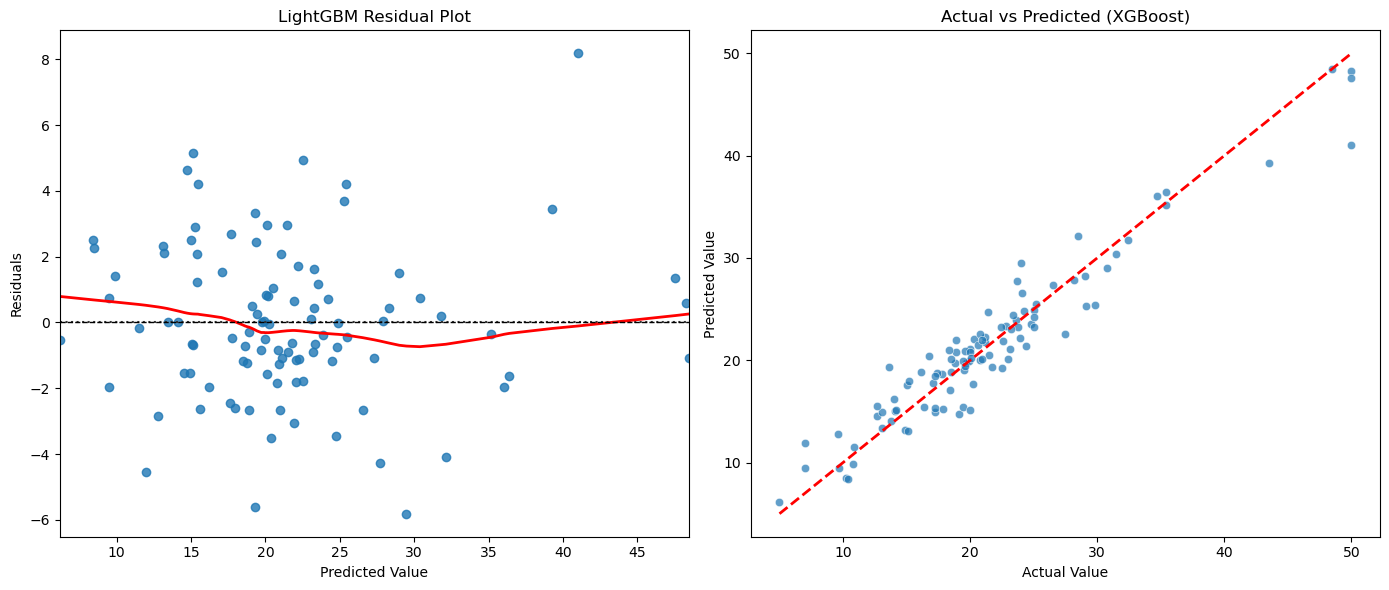

In [14]:
# 分割数据集为训练集和验证集（80% / 20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============ 4. 构建LightGBM数据集 ============
dtrain = lgb.Dataset(X_train, label=y_train)  # 训练集
dtest = lgb.Dataset(                          # 验证集
    X_test, 
    label=y_test
)

# ============ 5. 配置模型参数 ============
params = {
    # 任务类型和评估指标
    'objective': 'regression',   # 回归任务
    'metric': {'rmse','l1','l2'},   # 回归损失
    
    # 树结构控制
    'num_leaves': 60,       # 叶子节点数（控制模型复杂度）
    'max_depth': -1,        # -1表示不限制深度（通常用num_leaves控制）
    'min_data_in_leaf': 2, # 叶子节点最小样本数（防过拟合）
    
    # 训练过程控制
    'learning_rate': 0.03,  # 学习率（步长）
    'feature_fraction': 0.9, # 每轮随机选择90%特征
    'bagging_fraction': 0.8, # 每轮随机选择80%数据
    
    # 正则化
    'lambda_l1': 0.1,       # L1正则化系数
    'lambda_l2': 0.01,     # L2正则化系数
    
    # 其他
    'verbosity': -1,        # 静默模式（不输出训练日志）
    'seed': 2019    # 随机种子
}


# 训练模型
lgb_reg = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,    # 最大迭代轮数
    valid_sets=[dtrain, dtest],  # 监控训练集和验证集表现
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # 早停（50轮无提升停止）
        lgb.log_evaluation(period=50)            # 每50轮打印一次日志
    ]
)

# 使用训练好的模型对验证集进行预测
y_pred = lgb_reg.predict(X_test)

# 计算多种评估指标
mse = mean_squared_error(y_test, y_pred)               # 均方误差
rmse = np.sqrt(mse)                                    # 均方根误差
mae = mean_absolute_error(y_test, y_pred)              # 平均绝对误差
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # 平均绝对百分比误差
r2 = r2_score(y_test, y_pred)                          # 决定系数 R²（越接近1越好）

# 输出评估指标
print("=== 评估指标 (LightGBM 原生 API) ===")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# 计算残差（实际值 - 预测值）
residuals = y_test - y_pred

# 创建可视化图像（2 个子图）
plt.figure(figsize=(14, 6))

# 子图1：残差图（理想情况下残差应围绕0对称分布）
plt.subplot(1, 2, 1)
sns.residplot(x=y_pred, y=residuals, lowess=True,
              line_kws={'color': 'red', 'lw': 2})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Predicted Value")
plt.ylabel("Residuals")
plt.title("LightGBM Residual Plot")

# 子图2：实际值 vs 预测值（越接近对角线越好）
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Actual vs Predicted (XGBoost)")

# 自动调整图像排版
plt.tight_layout()
plt.show()

# shap可视化——全局特征重要性可视化

## 初始化解释器&计算shap值

In [15]:
import shap
shap.initjs()

# 初始化解释器
explainer = shap.Explainer(lgb_reg)

# 计算 SHAP 值（针对验证集）
shap_values = explainer(X_test)

## bar特征重要性条形图

### 基本概念

- **功能**：全局特征重要性条形图
- **计算方式**：
    - 默认使用 shap_values.abs.mean(0)（平均绝对SHAP值）
    - 可自定义聚合函数（通过 feature_values 参数）

### 特征重要性条形图的组成要素
- **横轴**：表示平均绝对SHAP值，数值越大表示特征对模型预测的影响越大
- **纵轴**：列出所有特征，按重要性从高到低排序
- **颜色**：通常使用单一颜色(如蓝色)表示所有特征，或在多类别问题中使用不同颜色区分不同类别

### `shap.plots.bar()`
- `shap_values`: 必需参数，包含SHAP值的对象，通常来自shap.Explainer的计算结果
- `max_display`: 限制显示的特征数量。默认值10
- `order`: 控制特征的排序方法
    - `shap.Explanation.abs`：按SHAP绝对值排序(默认)
    - `shap.Explanation.max`：按最大正值排序
    - `shap.Explanation.min`：按最小负值排序
    - `None`：保持原始顺序

### 代码实现与结果解释

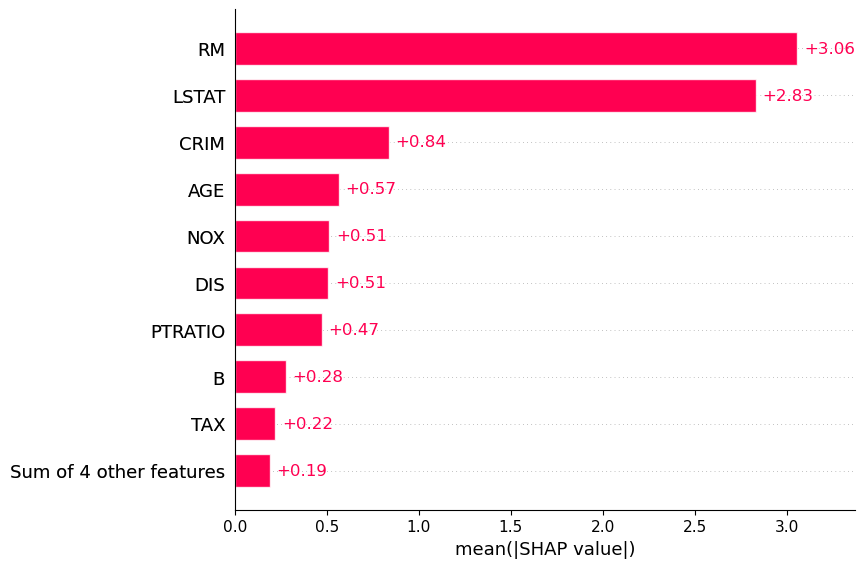

In [16]:
shap.plots.bar(shap_values)

**图表整体结构**
- **横轴**：显示`mean(|SHAP value|)`，数值范围0.0到3.06
- **纵轴**：按SHAP值大小降序排列的特征名称
- **条形颜色**：统一使用红色表示正向影响
- **数值标注**：每个条形末端标注具体SHAP值

**特征贡献分析**

| 特征名        | SHAP值   | 贡献方向 | 重要性排名 |
|---------------|----------|----------|--------------|
| RM            | +3.06    | 正向     | 1            |
| LSTAT         | +2.83    | 正向     | 2            |
| CRIM          | +0.84    | 正向     | 3            |
| AGE           | +0.57    | 正向     | 4            |
| NOX           | +0.51    | 正向     | 5            |
| DIS           | +0.51    | 正向     | 6            |
| PTRATIO       | +0.47    | 正向     | 7            |
| B             | +0.28    | 正向     | 8            |
| TAX           | +0.22    | 正向     | 9            |
| 其他4个特征   | +0.19    | 正向     | 10           |

**业务解读**
- **主导性正向影响因素**：
    - RM(平均房间数)：贡献+3.06，是模型预测的最主要驱动因素
    - LSTAT(低社会经济地位人口比例)：贡献+2.83，第二大影响因素
- **次要正向影响因素**：
    - CRIM(犯罪率)：贡献+0.84
    - AGE(房龄)：贡献+0.57
    - NOX(氮氧化物浓度)：贡献+0.51
- **特征重要性分布**：
    - 前两大特征(RM和LSTAT)贡献了约62%的总影响
    - 其他特征影响相对较小但均为正向

## beeswarm蜂群图

### 基本概念

- **功能**：蜂群图结合了特征重要性和特征值分布的信息，能够直观展示所有样本中各特征对模型预测的影响
- **特点**：
    - 每个点代表一个样本的特征SHAP值
    - 颜色表示特征值大小（红高蓝低）
    - 宽度表示特征出现频率

### 蜂群图的组成要素

- **基本构成**
    - **Y轴**：特征名称，按重要性排序
    - **X轴**：SHAP值范围，表示特征对预测的影响程度
    - **点集合**：每个点代表一个样本的特征影响
    - **颜色映射**：表示特征值的大小(默认红高蓝低)
- **关键解读要素**
    - **特征重要性**：垂直方向的位置反映特征的整体重要性
    - **影响方向**：点在X轴的位置表示影响的正面/负面性
    - **特征值分布**：颜色揭示特征值与SHAP值的关系
    - **样本密度**：点的堆积程度显示特定影响的样本集中度

### `shap.plots.beeswarm()`
- `shap_values`: 必需参数，包含SHAP值的对象，通常来自shap.Explainer的计算结果
- `max_display`: 限制显示的特征数量。默认值10
- `order`: 控制特征的排序方法
    - `shap.Explanation.abs`：按SHAP绝对值排序(默认)
    - `shap.Explanation.max`：按最大正值排序
    - `shap.Explanation.min`：按最小负值排序
    - `None`：保持原始顺序
- `color`: 颜色映射
    - None：自动使用特征值着色（默认值）
    - 数组：自定义颜色值(长度需匹配样本数)
    - 字符串：统一颜色(如"red")
- `alpha`: 透明度。默认值为1，取值范围0.0(完全透明)~1.0(完全不透明)
- `s`: 点大小
- `axis_color`: 坐标轴颜色
- `plot_size`: 图像尺寸
    - `auto`：自动计算。默认值
    - `float`：宽度(高度自动计算)
    - `(width, height)`：指定宽高
- `color_bar`: 是否显示颜色条。默认值True
- `color_bar_label`: 颜色条标签，也即。默认值'Feature value'

### 代码实现与结果解释

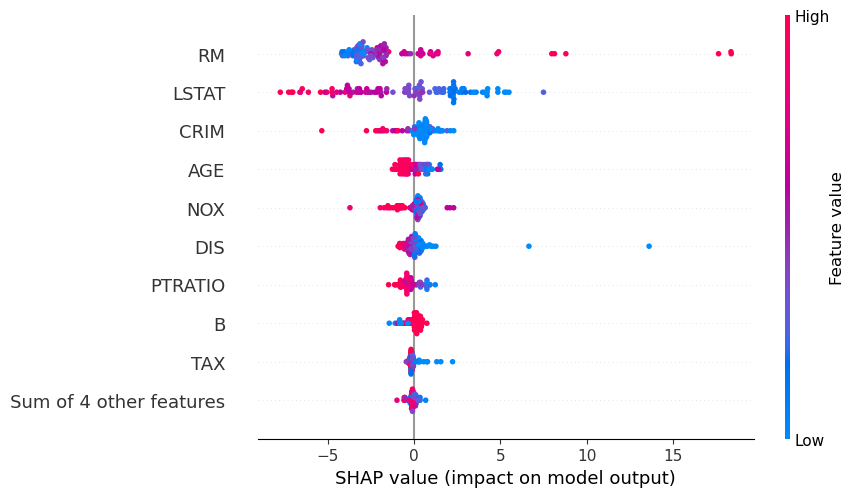

In [17]:
shap.plots.beeswarm(shap_values)

**图表整体结构**
- **横轴(SHAP值)**：范围-5到15，表示特征对预测的影响程度
    - 正值(右侧)：增加预测值
    - 负值(左侧)：降低预测值
- **纵轴(特征)**：按特征重要性降序排列，从上至下依次为：
    - RM → LSTAT → CRIM → AGE → NOX → DIS → PTRATIO → B → TAX → 其他4特征
- **点分布**：每个点代表一个样本，颜色从蓝(低特征值)到红(高特征值)
- **右侧颜色条**：标注"Feature value"，说明颜色与特征值的对应关系

**特征重要性分析**

| 特征名        | SHAP值范围   | 主要影响方向 | 颜色模式观察                                      | 重要性排名 | 业务解释                                                                 |
|---------------|--------------|---------------|---------------------------------------------------|------------|--------------------------------------------------------------------------|
| RM            | 0 ~ +15      | 强正向        | 红点(高值)密集右侧，蓝点(低值)分散左侧           | 1          | 房间数越多房价越高，符合房地产基本规律                                  |
| LSTAT         | -5 ~ +5      | 双向影响      | 红点(高值)偏左，蓝点(低值)偏右                   | 2          | 低收入人群比例高会降低房价                     |
| CRIM          | 0 ~ +5       | 正向为主      | 红点(高犯罪率)略左，蓝点(低犯罪率)略右           | 3          | 低犯罪率区域房价高                    |
| AGE           | -2 ~ +4      | 正向为主      | 颜色分布均匀无显著模式                            | 4          | 房龄影响非线性，可能反映历史建筑价值                                  |
| NOX           | -3 ~ +3      | 双向影响      | 红点(高污染)明显偏左                             | 5          | 高污染显著降低房价，但清洁区域不一定溢价                              |
| DIS           | -2 ~ +4      | 正向为主      | 蓝点(近距离)略右，红点(远距离)略左               | 6          | 适中的就业中心距离(2-5公里)价值最高                                    |
| PTRATIO       | -2 ~ +3      | 正向为主      | 颜色分布分散无规律                                | 7          | 优质学区(低PTRATIO)有溢价，但非决定性因素                             |
| B             | -1 ~ +2      | 正向为主      | 无明显分布模式                                   | 8          | 黑人比例影响复杂，可能反映区域种族构成                                |
| TAX           | -1 ~ +2      | 中性影响      | 分布对称于零值                                   | 9          | 财产税税率影响被其他特征覆盖                                           |
| 其他4特征     | -2 ~ +2      | 中性影响      | 集中分布在零值附近                               | 10         | 这些特征可能通过交互作用产生影响，单独影响弱                          |


**业务解读**
- **主要影响因素**
    - **RM(平均房间数)**
        - 最强正向驱动因素(SHAP值高达+15)
        - 明显正相关：房间数越多→房价越高
    - **LSTAT(低社会经济人口比例)**
        - 双向影响特征(SHAP值-5到+5)
        - 明显负相关：比例越高→房价越低
- **次要影响因素**
    - **CRIM(犯罪率)**：主要呈负向影响，但存在正向异常值。建议检查高犯罪率却高房价的样本特性
    - **NOX(氮氧化物浓度)**：高浓度明显拉低房价。空气质量对高端房产影响显著
- **特征交互观察**
    - **RM与LSTAT**：两者影响强度相当但方向相反，可能存在补偿效应
    - **AGE与DIS**：分布模式相似，可能反映"老城区"共同特征
    - **NOX与PTRATIO**：都显示环境因素对房价的影响